In [1]:
# import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np
import warnings
import random
import sklearn
import os 
np.random.seed(42069)
random.seed(42069)

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
import pySingleCellNet as pySCN
sc.set_figure_params(dpi = 160 )

In [4]:
def preprocess_pipeline(mydata, exclude_high_ribo = True, ribo_thresh = 35, exclude_high_mt = True, 
                        mt_thresh = 3, exclude_doublets = True, doublet_thresh = 98, exclude_sporad_genes = True, gThresh = 5,
                        exclude_bad_genes = True, remove_low_gene_count_cells=True, norm=False):
    
    
    print(f"Data shape is {mydata.shape}, prior to preprocessing")
    
    if exclude_high_ribo:
        # remove high ribo expressing cells
        mydata.var['ribo'] = mydata.var_names.str.startswith(("Rps","Rpl"))
        sc.pp.calculate_qc_metrics(mydata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)
        mydata = mydata[mydata.obs['pct_counts_ribo'] < ribo_thresh, :]  
    print(f"Data shape is {mydata.shape}, after removing cells with high expr of ribo genes")
    
    if exclude_high_mt:
        # remove high mt expressing cells 
        mydata.var['mt']= mydata.var_names.str.startswith(("mt-"))
        sc.pp.calculate_qc_metrics(mydata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        mydata = mydata[mydata.obs['pct_counts_mt'] < mt_thresh, :]
    print(f"Data shape is {mydata.shape}, after removing cells with high expr of mito genes")
        
    if exclude_doublets:
        # remove doublets using 10x rec'd thresh
        thresh = np.percentile(mydata.obs['total_counts'], doublet_thresh)
        mydata = mydata[mydata.obs['total_counts'] < thresh, :]
    print(f"Data shape is {mydata.shape}, after removing possible doublets")
        
    if exclude_sporad_genes:
        # remove bad genes that are expressed in less than 5 cells
        sc.pp.filter_genes(mydata, min_cells=gThresh)
    print(f"Data shape is {mydata.shape}, after removing sporadic genes")
        
    if exclude_bad_genes:
        # get mt, ribo genes and Malat1 for removal
        mito_genes = mydata.var_names.str.startswith('mt-')
        ribo_genes = mydata.var_names.str.startswith(("Rpl","Rps"))
        malat_gene = mydata.var_names.str.startswith("Malat1")

        # remove em
        remove = np.add(mito_genes, ribo_genes)
        remove = np.add(remove, malat_gene)

        keep = np.invert(remove)

        # remove these BAD genes
        mydata = mydata[:,keep].copy()
        
    if remove_low_gene_count_cells: 
        print(f"Data shape is {mydata.shape}, after removing genes with little information")

        sc.pp.calculate_qc_metrics(mydata, percent_top=None, log1p=False, inplace=True)    
        mydata = mydata[mydata.obs["n_genes_by_counts"] >= 500, :].copy()
        print(f"Data shape is {mydata.shape}, after removing cells with low gene count")
        
    if norm:
        sc.pp.normalize_total(mydata, target_sum=1e4)
    
    return mydata

##### Prepare Data (Load, QC, Retain only common genes)

In [5]:
# read in subsampled data (fibroblasts that are pushed to become cardiomyocytes)
adata = sc.read_h5ad('renamed.h5ad')
adata = preprocess_pipeline(adata, exclude_high_ribo = True, ribo_thresh = 15, 
                            exclude_high_mt = True, mt_thresh = 0.5, exclude_doublets = True, 
                            doublet_thresh = 95, exclude_sporad_genes = True, gThresh = 0,
                            exclude_bad_genes = True)

Data shape is (3650, 33694), prior to preprocessing
Data shape is (3650, 33694), after removing cells with high expr of ribo genes
Data shape is (3650, 33694), after removing cells with high expr of mito genes
Data shape is (3467, 33694), after removing possible doublets
Data shape is (3467, 33694), after removing sporadic genes
Data shape is (3467, 33694), after removing genes with little information
Data shape is (2440, 33694), after removing cells with low gene count


In [6]:
adata = adata[:, adata.var['mouse_ortholog']!='LOL']

In [7]:
adata.var.index = adata.var['mouse_ortholog']

In [8]:
adata = adata[:, ~adata.var.index.duplicated(keep='first')]
adata.var.index = adata.var['mouse_ortholog']

In [9]:
# read in the reference adata/training data (containing fibroblasts, cardiomyocytes, and so on)
adTrain= sc.read_h5ad('TM_FACS_heart.h5ad')
adTrain = preprocess_pipeline(adTrain, exclude_high_ribo = True, ribo_thresh = 8, 
                              exclude_high_mt = False, mt_thresh = 0.5, exclude_doublets = True, 
                              doublet_thresh = 95, exclude_sporad_genes = True, gThresh = 0,
                              exclude_bad_genes = True)

Data shape is (4337, 23433), prior to preprocessing
Data shape is (4330, 23433), after removing cells with high expr of ribo genes
Data shape is (4330, 23433), after removing cells with high expr of mito genes
Data shape is (4113, 23433), after removing possible doublets
Data shape is (4113, 23433), after removing sporadic genes
Data shape is (4113, 23330), after removing genes with little information
Data shape is (4112, 23330), after removing cells with low gene count


In [10]:
# lets see how many genes are shared between our training data and query data
genesTrain = adTrain.var_names
genesQuery = adata.var_names

# let's see how many genes overlap
cgenes = genesTrain.intersection(genesQuery)
print(f"There are {len(cgenes)} shared genes between 2 datasets")
# 15 shared genes

There are 14825 shared genes between 2 datasets


In [11]:
# keep only the shared genes in the train data
adTrain1 = adTrain[:,cgenes]
print(f"Shape of Training set {adTrain1.shape}")

# keep only shared genes in our query data
adQuery = adata[:,cgenes].copy()
print(f"Shape of target dataset {adQuery.shape}")

Shape of Training set (4112, 14825)
Shape of target dataset (2440, 14825)


Both our query and train datas have the same geens now. The query data only contains cells with more than 500 genes as well.

##### Train/Evaluate Classifier

In [12]:
adTrain1=adTrain

In [13]:
adTrain1.obs['cell_ontology_class'].value_counts()

fibroblast             1980
endothelial cell       1153
leukocyte               469
myofibroblast cell      172
endocardial cell        165
cardiac muscle cell     133
smooth muscle cell       40
Name: cell_ontology_class, dtype: int64

In [14]:
# split reference data intro train and held out data
expTrain, expVal = pySCN.splitCommonAnnData(adTrain1, ncells=150, dLevel="cell_ontology_class")

smooth muscle cell : 
40
endothelial cell : 
1153
endocardial cell : 
165
myofibroblast cell : 
172
leukocyte : 
469
fibroblast : 
1980
cardiac muscle cell : 
133


HVG
Matrix normalized
There are  749  classification genes

cardiac muscle cell
endocardial cell
endothelial cell
fibroblast
leukocyte
myofibroblast cell
smooth muscle cell
There are 692 top gene pairs

Finished pair transforming the data



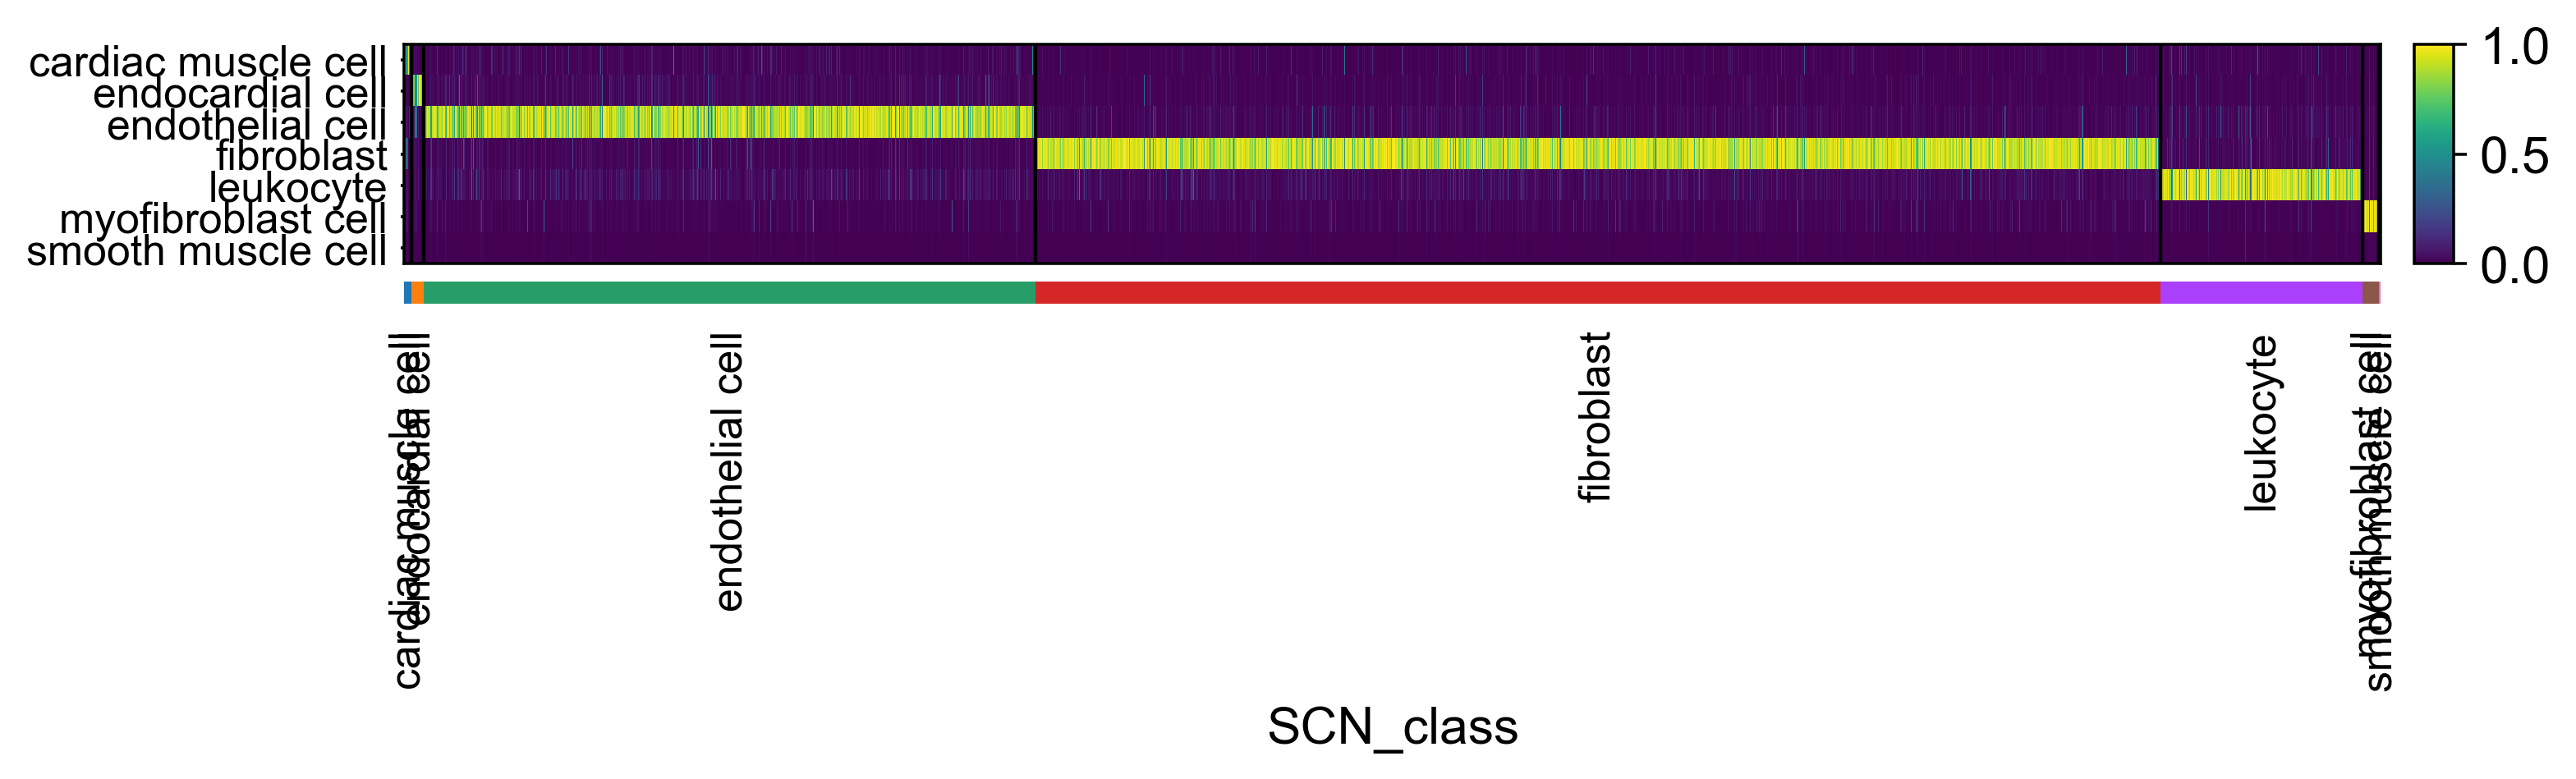

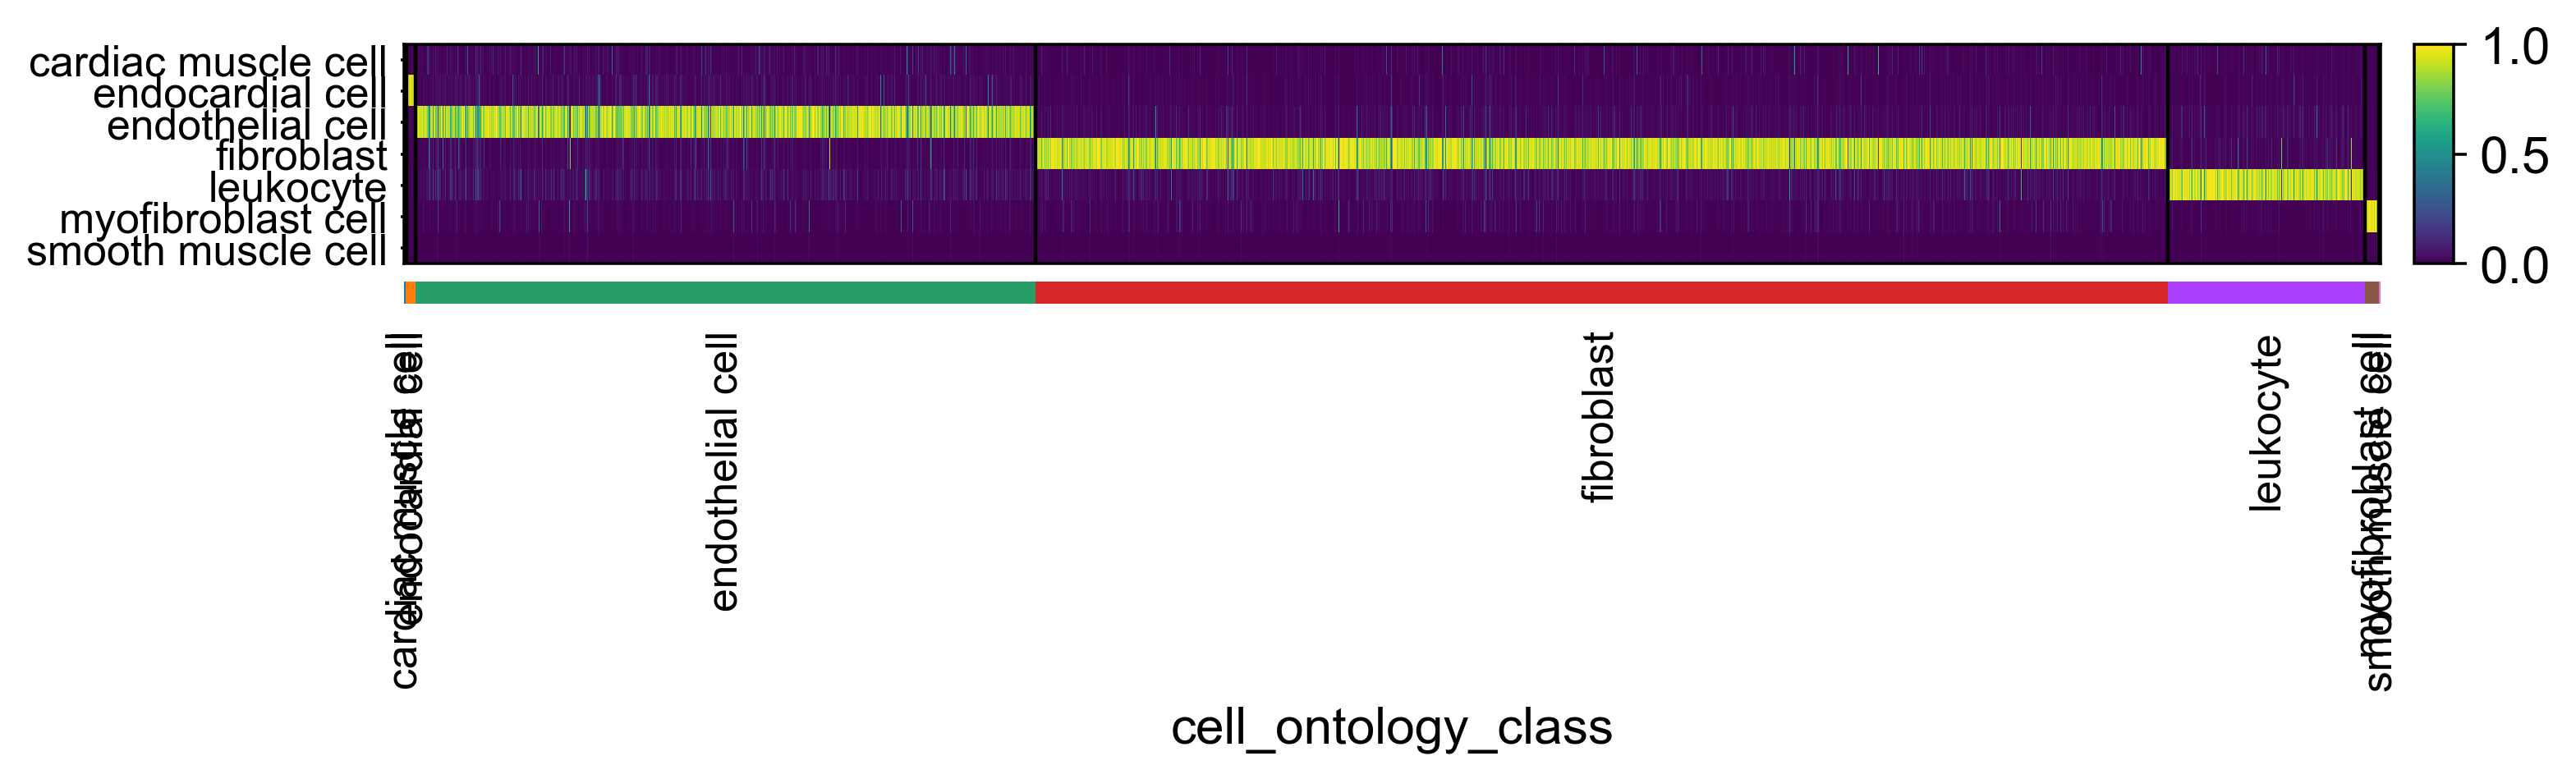

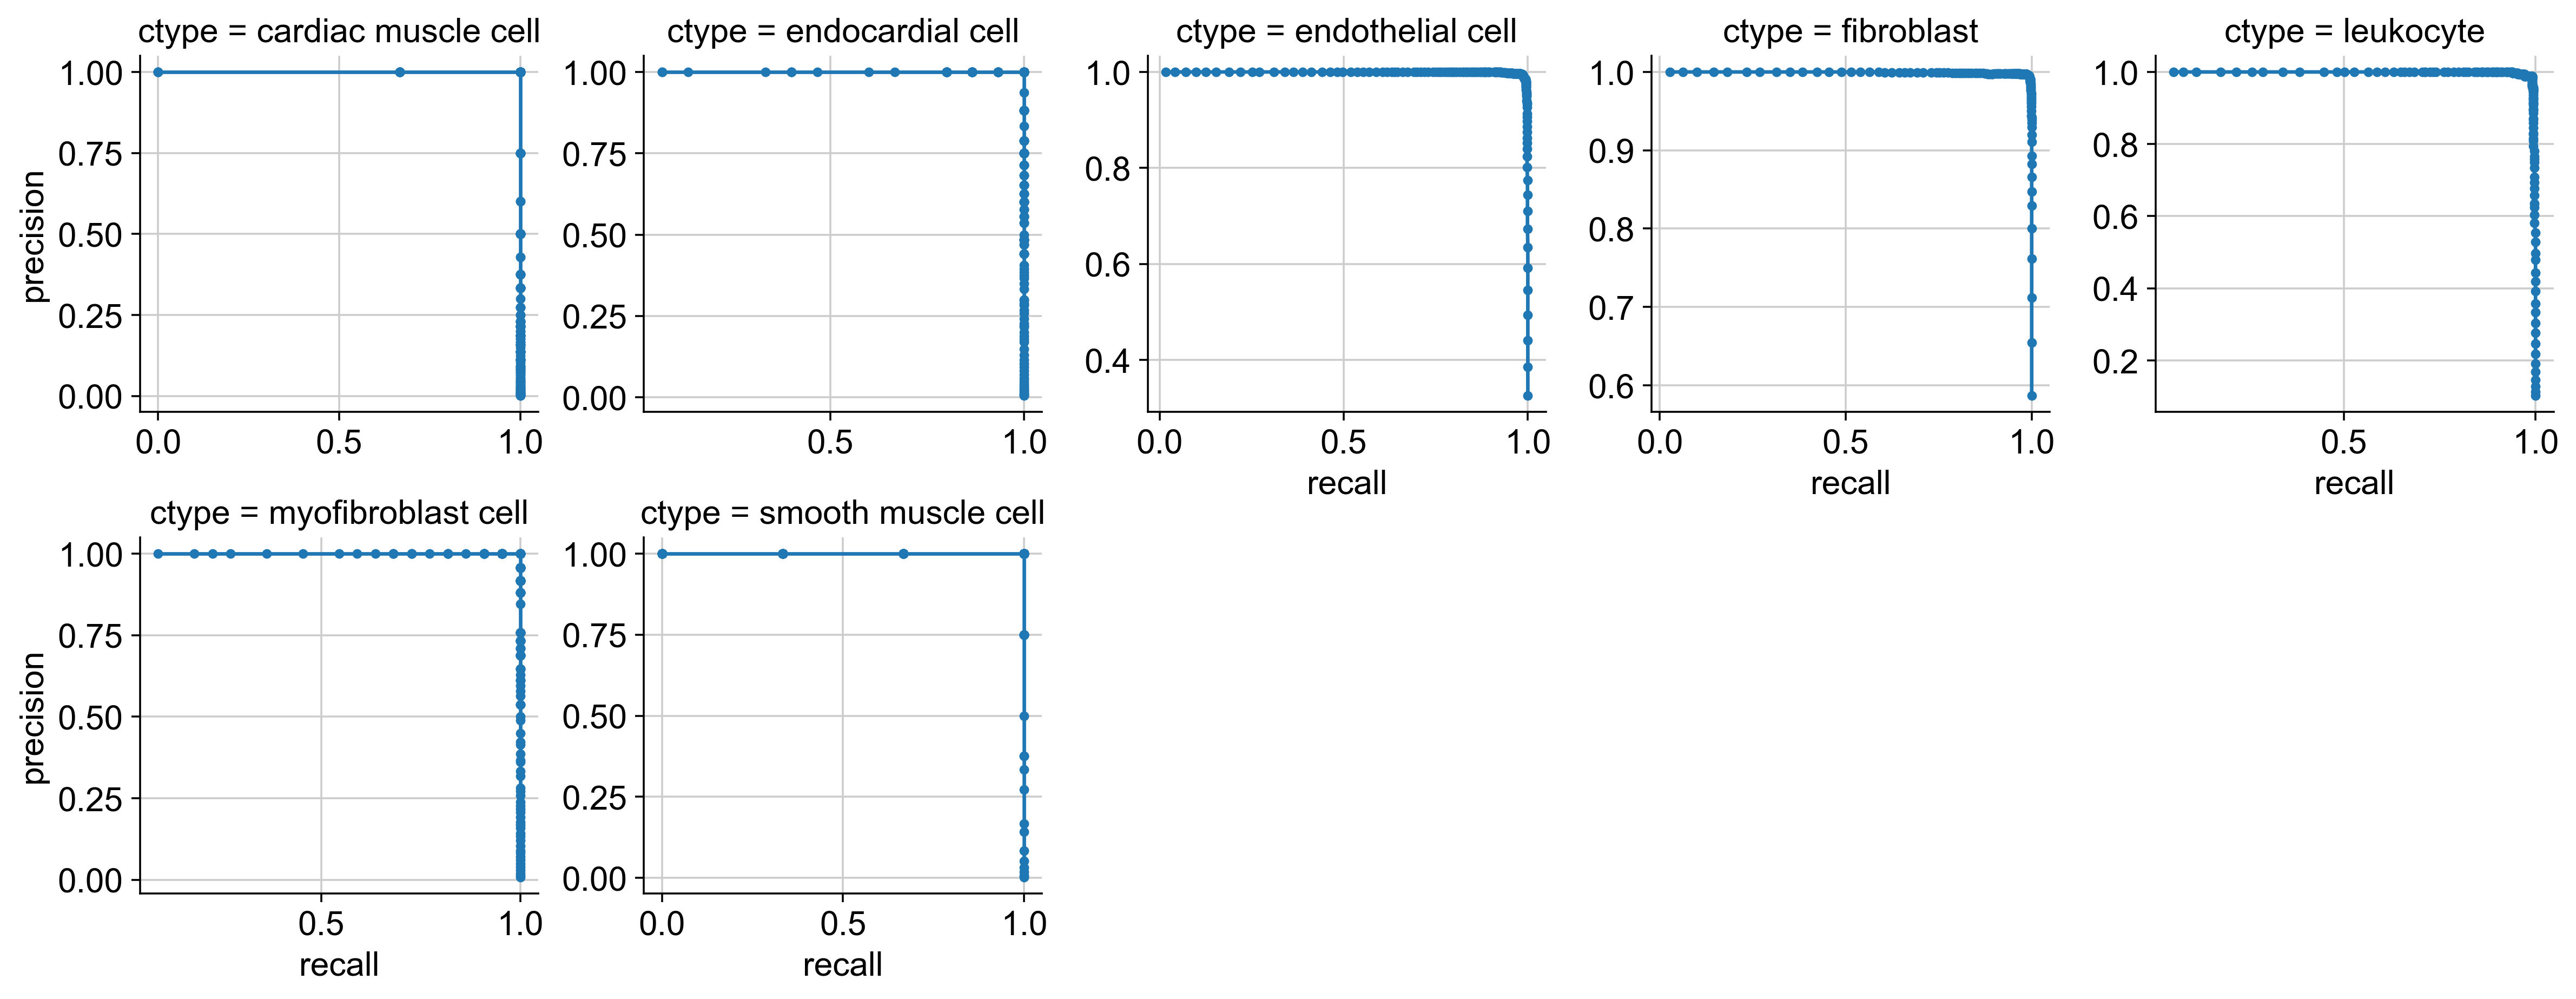

Accuracy: 0.9881064162754304


In [15]:
# train the classifier 
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 0, nTrees = 1000 ,nTopGenePairs = 100, 
                                           dLevel = "cell_ontology_class", stratify=True, limitToHVG=True)

# classify held out data and visualize 
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)

# plot grouped by predicted cell label aka the cell_ontology_class with the highest probability 
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

# y axis is cell types in the classifier, x axis is true cell labels
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='cell_ontology_class', cmap='viridis', dendrogram=False, swap_axes=True)

# looks pretty accurate

# determine how well classifier predicts cell types of held out data and visualize 
assessment =  pySCN.assess_comm(expTrain, adVal, resolution = 0.005, nRand = 0, dLevelSID = "cell", 
                                classTrain = "cell_ontology_class", classQuery = "cell_ontology_class")
pySCN.plot_PRs(assessment)
plt.show()

# figure out params to improve cardiac muscle cell precision 

# print accuracy 
print('Accuracy:', assessment['accuracy'])

In [16]:
adQuery.X = adQuery.X.todense()

##### Assess the quality of direct programming (fibroblast -> cardiomyocyte)

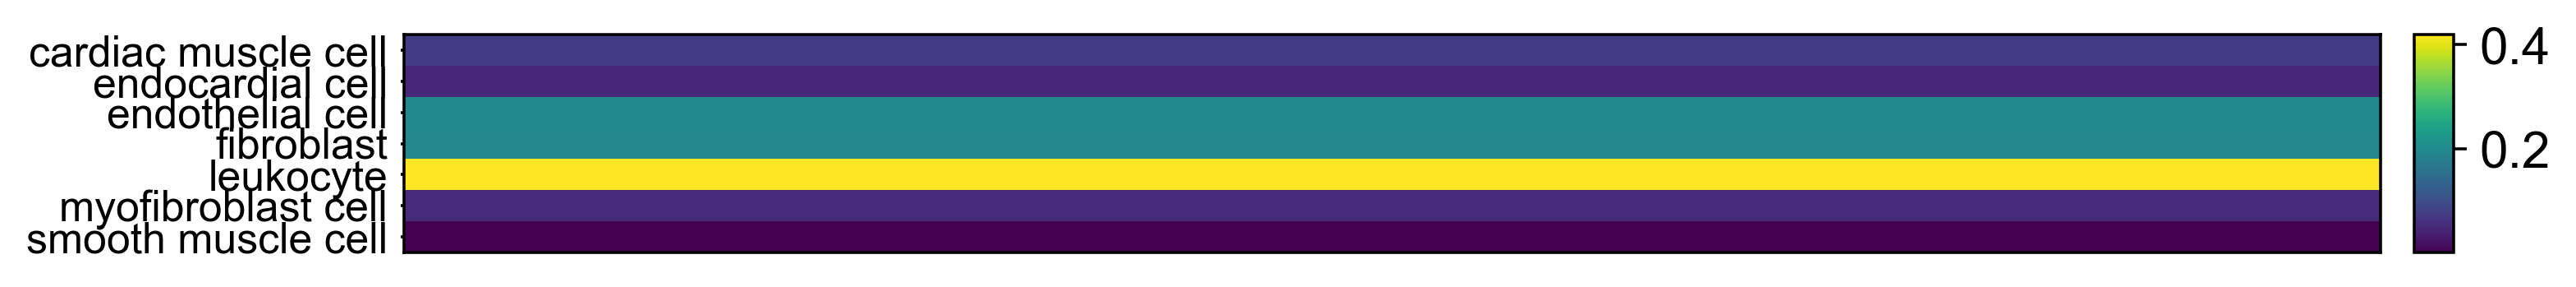

leukocyte    2440
Name: SCN_class, dtype: int64

In [17]:
# classifiy independent query data
adQ = pySCN.scn_classify(adQuery, cgenesA, xpairs, tspRF, nrand = 0)

ax = sc.pl.heatmap(adQ, adQ.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

# how many of each predicited type 
# cardiac muscle cell + fibroblast
adQ.obs['SCN_class'].value_counts()

In [18]:
adQuery.X

ArrayView([[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 1., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Question 2
How mature are your engineered cadriomyocytes?

In [19]:
adata = sc.read_h5ad('renamed.h5ad')

In [20]:
adata = adata[:, adata.var['mouse_ortholog']!='LOL']

In [21]:
adata.var.index = adata.var['mouse_ortholog']

In [22]:
adata = adata[:, ~adata.var.index.duplicated(keep='first')]
adata.var.index = adata.var['mouse_ortholog']

In [23]:
# assign cell type to data
human_clusters = pd.read_csv('clusters.tsv', delimiter='\t')

In [24]:
# drop rep*_ in cell.id
for count, id_ in enumerate(human_clusters['cell.id']):
    human_clusters['cell.id'][count] = id_.split('_')[1]

In [25]:
human_clusters

,cell.id,celltype
0,AAACCTGAGAAGGTTT-1,Cardiomyocytes
1,AAACCTGAGCATCATC-1,Cardiomyocytes
2,AAACCTGCAGACGTAG-1,Other
3,AAACCTGGTCGTGGCT-1,Other
4,AAACCTGGTTTCGCTC-1,Cardiomyocytes
...,...,...
3597,TTTGGTTTCTCTGAGA-1,Cardiomyocytes
3598,TTTGGTTTCTGTGCAA-1,Cardiomyocytes
3599,TTTGTCAGTCTCCACT-1,Other
3600,TTTGTCATCCTACAGA-1,Cardiomyocytes


In [26]:
adata_subset = adata[np.intersect1d(list(adata.obs_names), list(human_clusters['cell.id']))]

In [27]:
adata_subset.obs['celltype'] = human_clusters['celltype'].to_numpy()

In [28]:
adata_subset.obs['celltype']

AAACCTGAGAAGGTTT-1    Cardiomyocytes
AAACCTGAGCATCATC-1    Cardiomyocytes
AAACCTGCAGACGTAG-1             Other
AAACCTGGTCGTGGCT-1             Other
AAACCTGGTTTCGCTC-1    Cardiomyocytes
                           ...      
TTTGGTTTCTCTGAGA-1    Cardiomyocytes
TTTGGTTTCTGTGCAA-1    Cardiomyocytes
TTTGTCAGTCTCCACT-1             Other
TTTGTCATCCTACAGA-1    Cardiomyocytes
TTTGTCATCTTAACCT-1             Other
Name: celltype, Length: 3602, dtype: object

In [29]:
# import the perinatal reference set
adRef = sc.read_h5ad('perinatal_reference_data/Kannan_perinatal_reference.h5ad')

In [30]:
df = pd.read_csv("kannan et al mitomap.txt", delimiter='\t', index_col=None).to_numpy()

In [31]:
def preproc_for_kannan(mydata, interest = 'timepoint', infer = False):

    data = mydata.copy()

    for [name, alts] in df:
        for alt in alts.split(';'):
            if alt == name:            # If re-assign mito gene to isefl
                continue
            alt_loc = np.where(data.var.index == alt)
            nam_loc = np.where(data.var.index == name)
            if len(alt_loc[0]) == 0:   # If pseudo gene doesn't exist
                continue
                
            if len(nam_loc[0]) == 0:
                data.var.index = list(data.var.index[:alt_loc[0][0]]) + [name] + list(data.var.index[alt_loc[0][0]+1:])
            else:
                data.X[:,nam_loc[0][0]] += data.X[:,alt_loc[0][0]]
                slice_off = [True if i != alt_loc[0][0] else False for i in range(len(data.var.index))]
                data = data[:, slice_off]
                
            print(alt_loc, nam_loc, data.shape)
        
    ribo_genes = data.var_names.str.startswith(("Rpl", "Rps"))
    malat_gene = data.var_names.str.startswith("Malat1")
    data = data[:, np.invert(ribo_genes | malat_gene)]

    to_remove = [False for i in range(data.shape[0])]
    if infer:
        for timepoint in set(data.obs[interest]):
            val = data[data.obs[interest] == timepoint]

            top5gene = [np.sum(np.sort(row)[-5:]) for row in val.X]
            median   = np.percentile(top5gene, 50)
            location = np.where((top5gene / median) > 1.5)[0]                 # Mark all 1.3 above median
            for name in val.obs.index[location]:
                to_remove[np.where(data.obs.index == name)[0][0]] = True

            sc.pp.calculate_qc_metrics(val, qc_vars=[], percent_top=None, log1p=False, inplace=True)
            median = np.percentile(val.obs['total_counts'], 50)
            location = np.where(np.log(val.obs['total_counts'] / median) < -1)[0]
            for name in val.obs.index[location]:
                to_remove[np.where(data.obs.index == name)[0][0]] = True

    data = data[~np.array(to_remove)]
    print(data.shape)
            
    return data
    
preproc = preproc_for_kannan(adRef, infer = True)

(array([19093]),) (array([15880]),) (936, 29592)
(array([24215]),) (array([15873]),) (936, 29591)
(array([15874]),) (array([15873]),) (936, 29590)
(array([24304]),) (array([15870]),) (936, 29589)
(array([19285]),) (array([15870]),) (936, 29588)
(array([22675]),) (array([15878]),) (936, 29587)
(array([18724]),) (array([15878]),) (936, 29586)
(array([24488]),) (array([15874]),) (936, 29585)
(array([28099]),) (array([15866]),) (936, 29584)
(array([19013]),) (array([15866]),) (936, 29583)
(array([15873]),) (array([], dtype=int64),) (936, 29583)
(array([25404]),) (array([15873]),) (936, 29582)
(array([19144]),) (array([15881]),) (936, 29581)
(array([12565]),) (array([], dtype=int64),) (936, 29581)
(array([24260]),) (array([], dtype=int64),) (936, 29581)
(array([24524]),) (array([15872]),) (936, 29580)
(array([19413]),) (array([15872]),) (936, 29579)
(array([18973]),) (array([15872]),) (936, 29578)
(array([22769]),) (array([15861]),) (936, 29577)
(array([24005]),) (array([], dtype=int64),) (

In [32]:
def shannonEntropy(preprocessedMydata):
    """
    TODO
    """
    GeneMeanExpr = np.mean(preprocessedMydata.X, axis=0)
    Top1000Gene  = np.array(np.argsort(GeneMeanExpr)).flatten()[-1000:]
    Subset       = preprocessedMydata[:, Top1000Gene]
    Proportion   = Subset.X / np.array(np.sum(Subset.X, axis=1)).flatten()[:, np.newaxis]
    log2         = np.log2(Proportion)
    log2         = np.nan_to_num(log2, neginf=0, posinf=0, nan=0)
    EntropyScore = -np.sum(np.array(Proportion) * np.array(log2), axis=1)
    return EntropyScore

In [33]:
# subset adata for cm's 
adata_subset_CM = adata_subset[adata_subset.obs['celltype'] == 'Cardiomyocytes']
adata_subset_CM.obs

,celltype
AAACCTGAGAAGGTTT-1,Cardiomyocytes
AAACCTGAGCATCATC-1,Cardiomyocytes
AAACCTGGTTTCGCTC-1,Cardiomyocytes
AAACGGGAGCCGCCTA-1,Cardiomyocytes
AAACGGGGTGAAGGCT-1,Cardiomyocytes
...,...
TTTGGTTGTTTCGCTC-1,Cardiomyocytes
TTTGGTTTCTAACGGT-1,Cardiomyocytes
TTTGGTTTCTCTGAGA-1,Cardiomyocytes
TTTGGTTTCTGTGCAA-1,Cardiomyocytes


In [34]:
refEntropyScore = shannonEntropy(preproc)
adata_subset = preproc_for_kannan(adata_subset)
queryEntropyScore = shannonEntropy(adata_subset_CM)

(3602, 16870)


<AxesSubplot:xlabel='timepoint', ylabel='Score'>

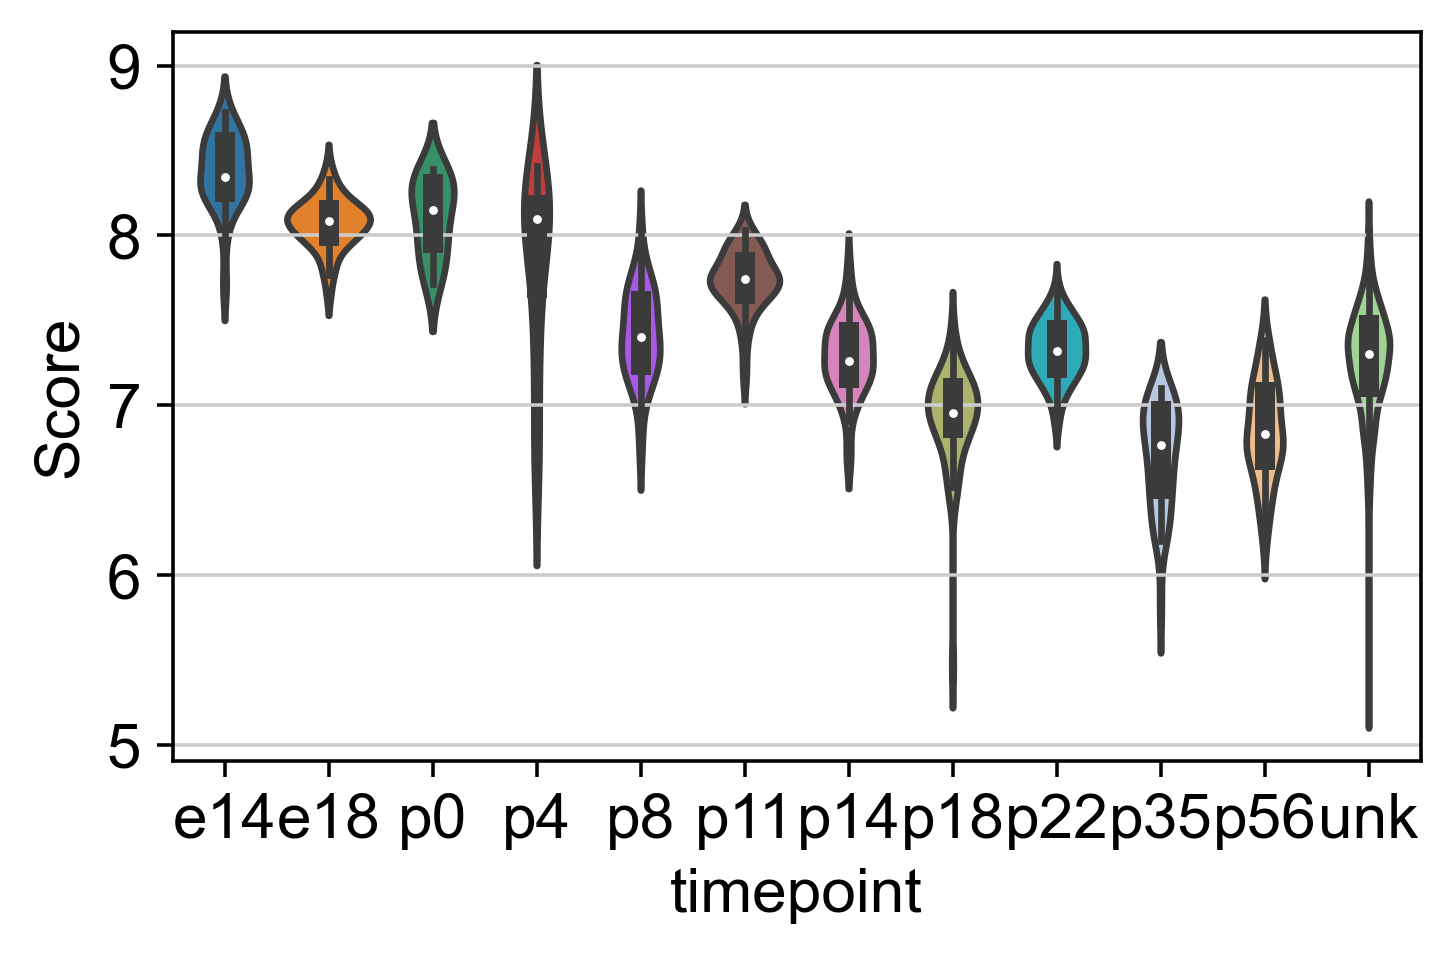

In [35]:
refPlot = pd.DataFrame(refEntropyScore, columns=["Score"])
refPlot['timepoint'] = list(preproc.obs['timepoint'])
refPlotSorted = refPlot.sort_values(by='timepoint')

queryPlot = pd.DataFrame(queryEntropyScore, columns=["Score"])
queryPlot['timepoint'] = ["unk" for i in range(len(queryEntropyScore))]

overall = pd.concat([refPlot, queryPlot], axis=0)

plt.figure(figsize=(5, 3))
sns.violinplot(data=overall, x='timepoint', 
               y='Score', 
               order=['e14', 'e18', 'p0', 'p4', 'p8', 
                      'p11', 'p14', 'p18', 'p22', 'p35', 'p56', "unk"])

Our human cells are around HE7

In [36]:
adCM = adata_subset[adata_subset.obs['celltype'] == 'Cardiomyocytes']
adCM_proc = preprocess_pipeline(adCM, exclude_high_ribo = False, ribo_thresh = 35, exclude_high_mt = False, 
                        mt_thresh = 3, exclude_doublets = False, doublet_thresh = 98, exclude_sporad_genes = True, gThresh = 5,
                        exclude_bad_genes = True, remove_low_gene_count_cells=False, norm=True)

Data shape is (1922, 16870), prior to preprocessing
Data shape is (1922, 16870), after removing cells with high expr of ribo genes
Data shape is (1922, 16870), after removing cells with high expr of mito genes
Data shape is (1922, 16870), after removing possible doublets
Data shape is (1922, 10440), after removing sporadic genes


### Question 3

In [37]:
tf_ip_df = pd.read_csv('tf_ip_scores.csv', index_col=[0])

In [38]:
tf_ip_df

,Klf6,Smarcb1,Sp1,Nr1h3,Relb,Plag1,Etv3,Fosb,Stat3,Stat5a,...,Hic2,Prdm9,Klf13,Creb5,Thra,Stat4,Zbtb16,Zfp652,Chd2,Zfp82
0,70.401667,46.182579,24.871156,-6.758699,-2.111394,-0.430478,-4.138089,27.26514,68.657904,-7.208374,...,14.744422,-4.385751,90.263033,57.392702,73.820228,-3.201189,19.810807,0.888992,112.300597,-4.215529
4,-85.191056,-45.266264,-28.292176,11.143947,1.609024,0.948899,5.139359,-26.98259,-60.814931,7.776666,...,-17.729002,8.415177,-85.243073,-66.117722,-58.091097,8.834934,-14.540570,-0.245831,-97.302377,8.424646


In [39]:
adCM_proc.var.index = adCM_proc.var['mouse_ortholog']
adCM_proc.X = adCM_proc.X.todense()

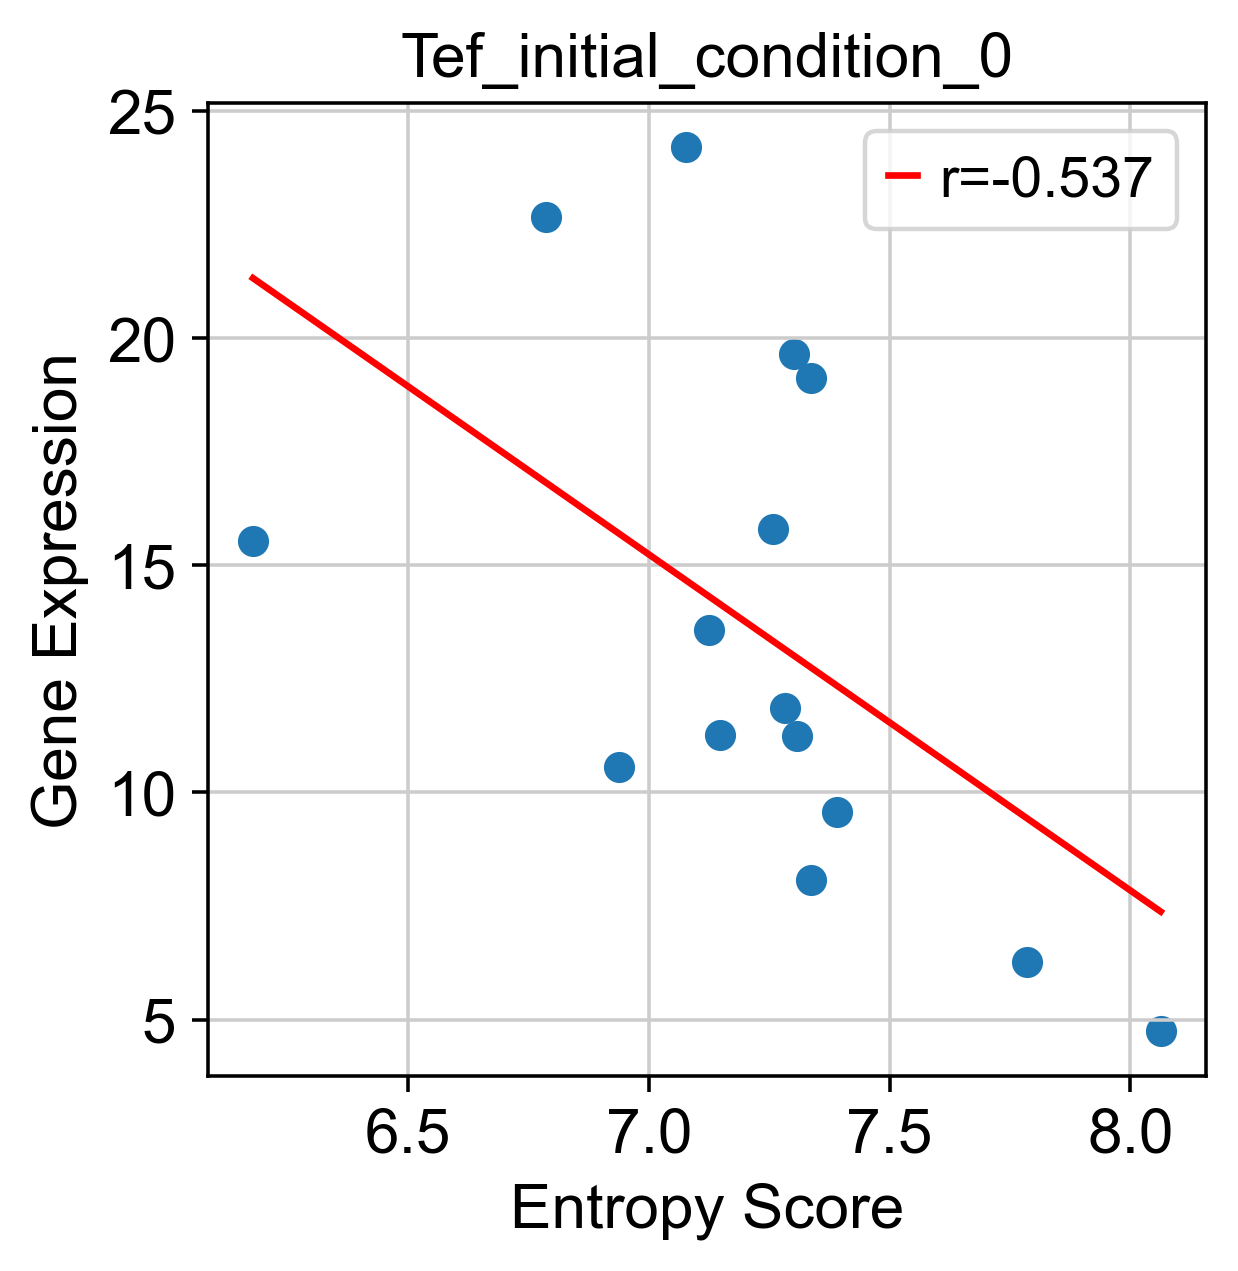

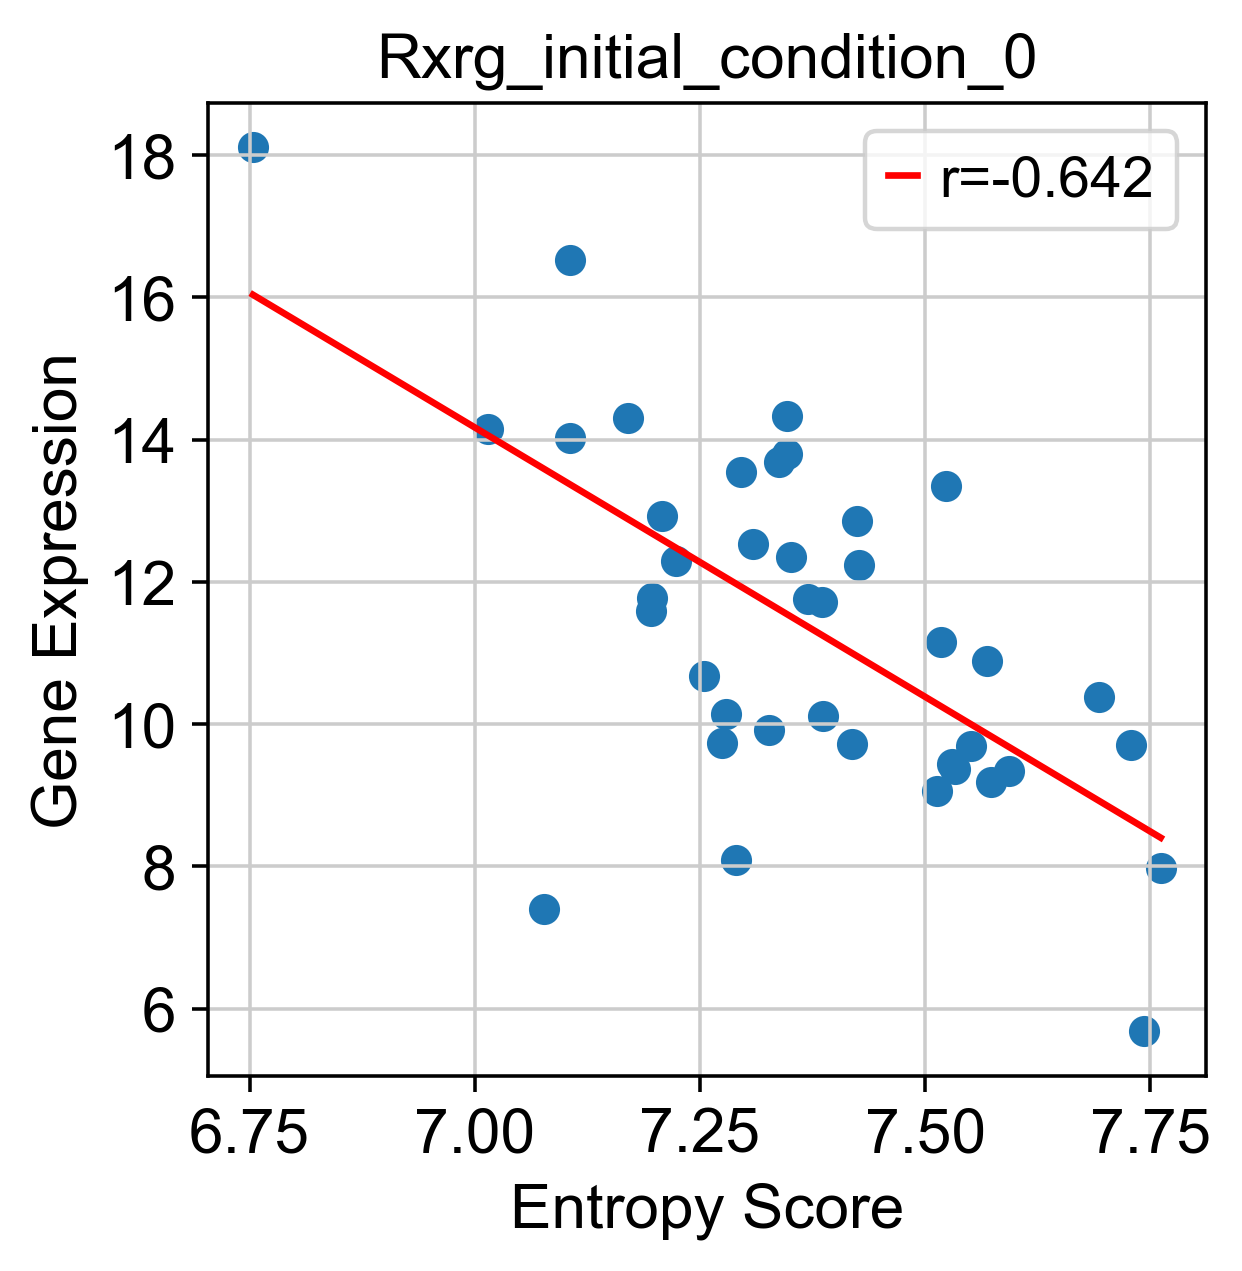

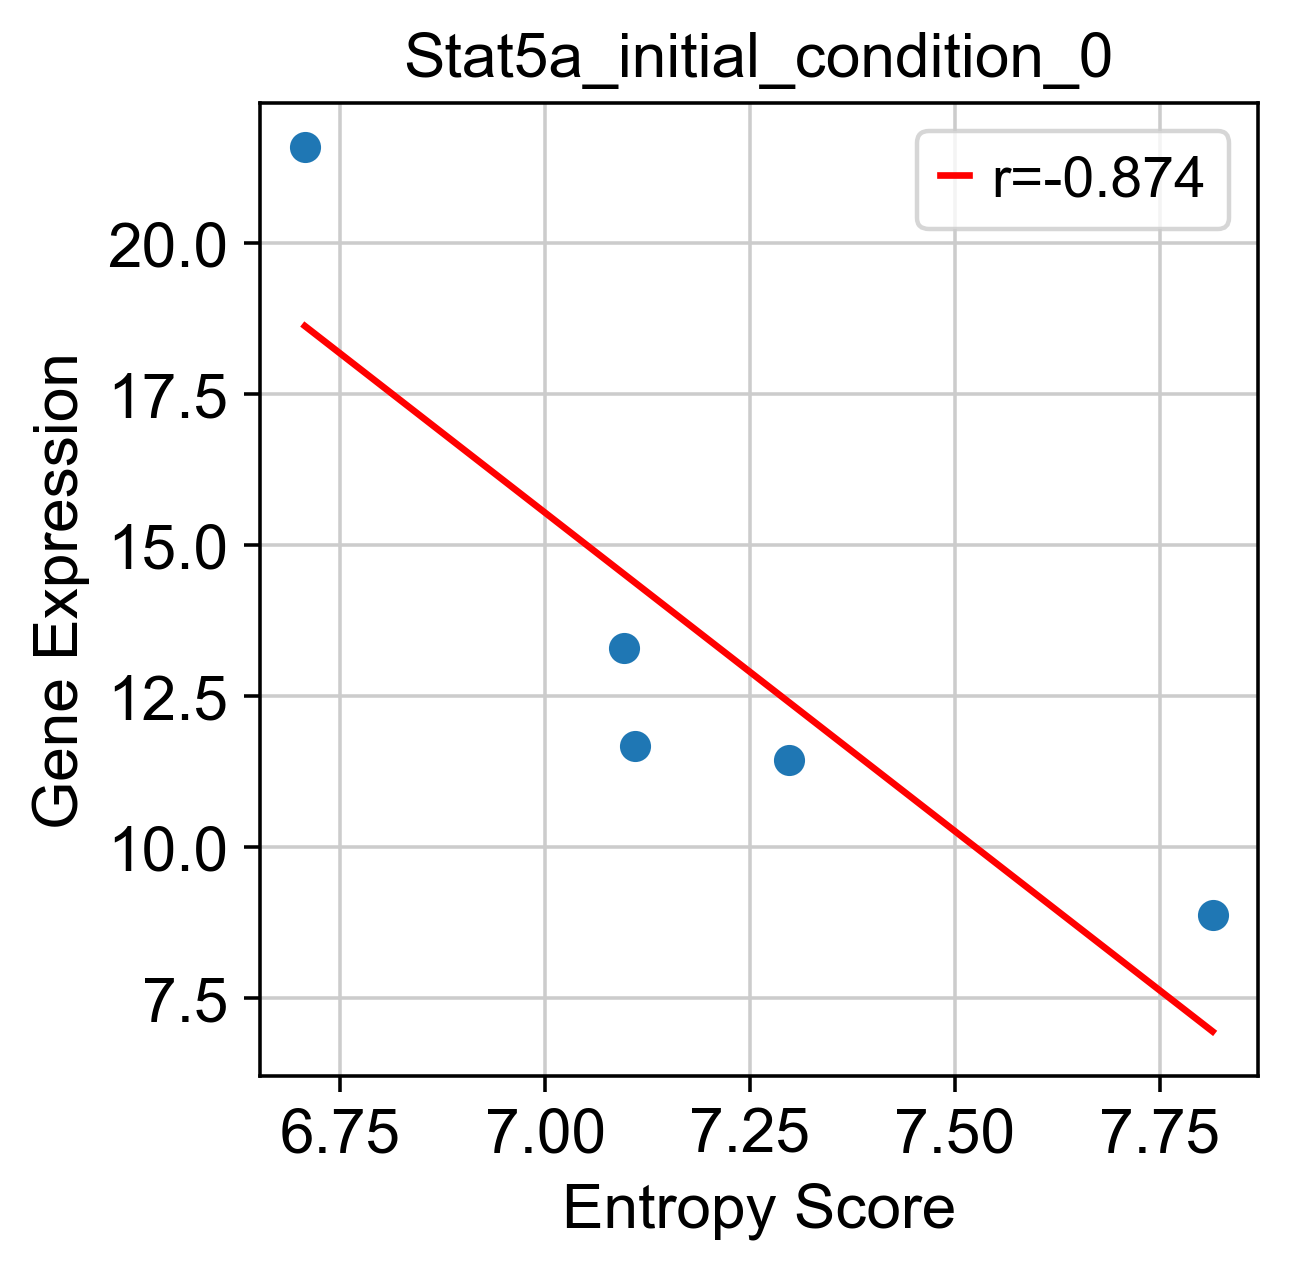

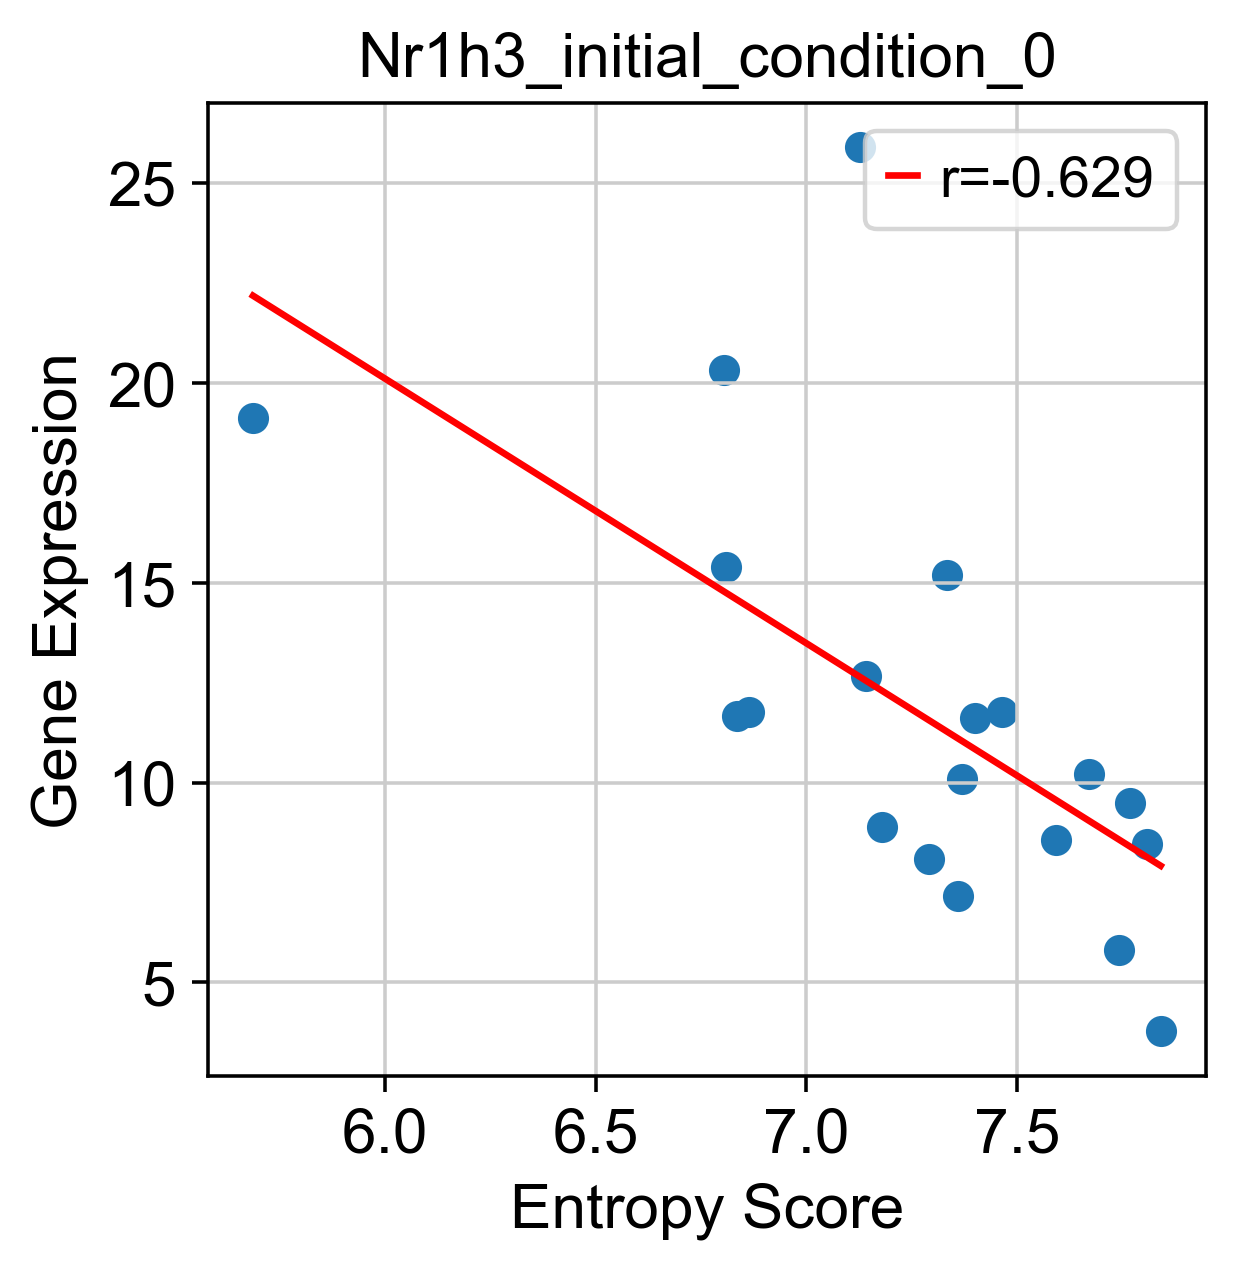

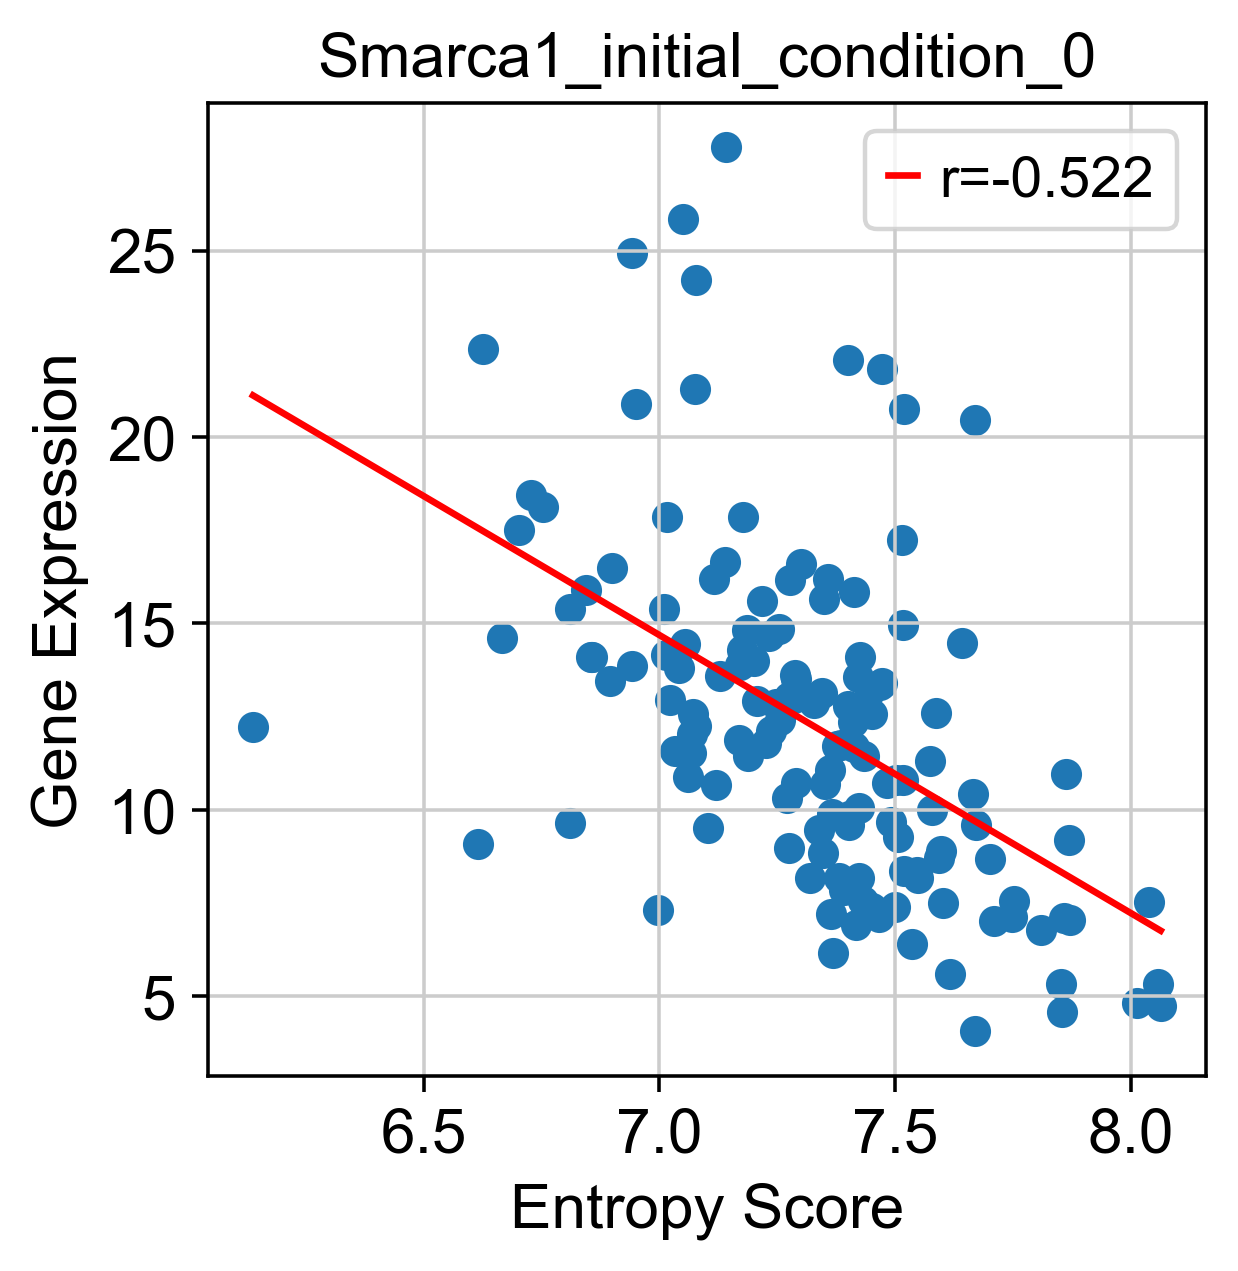

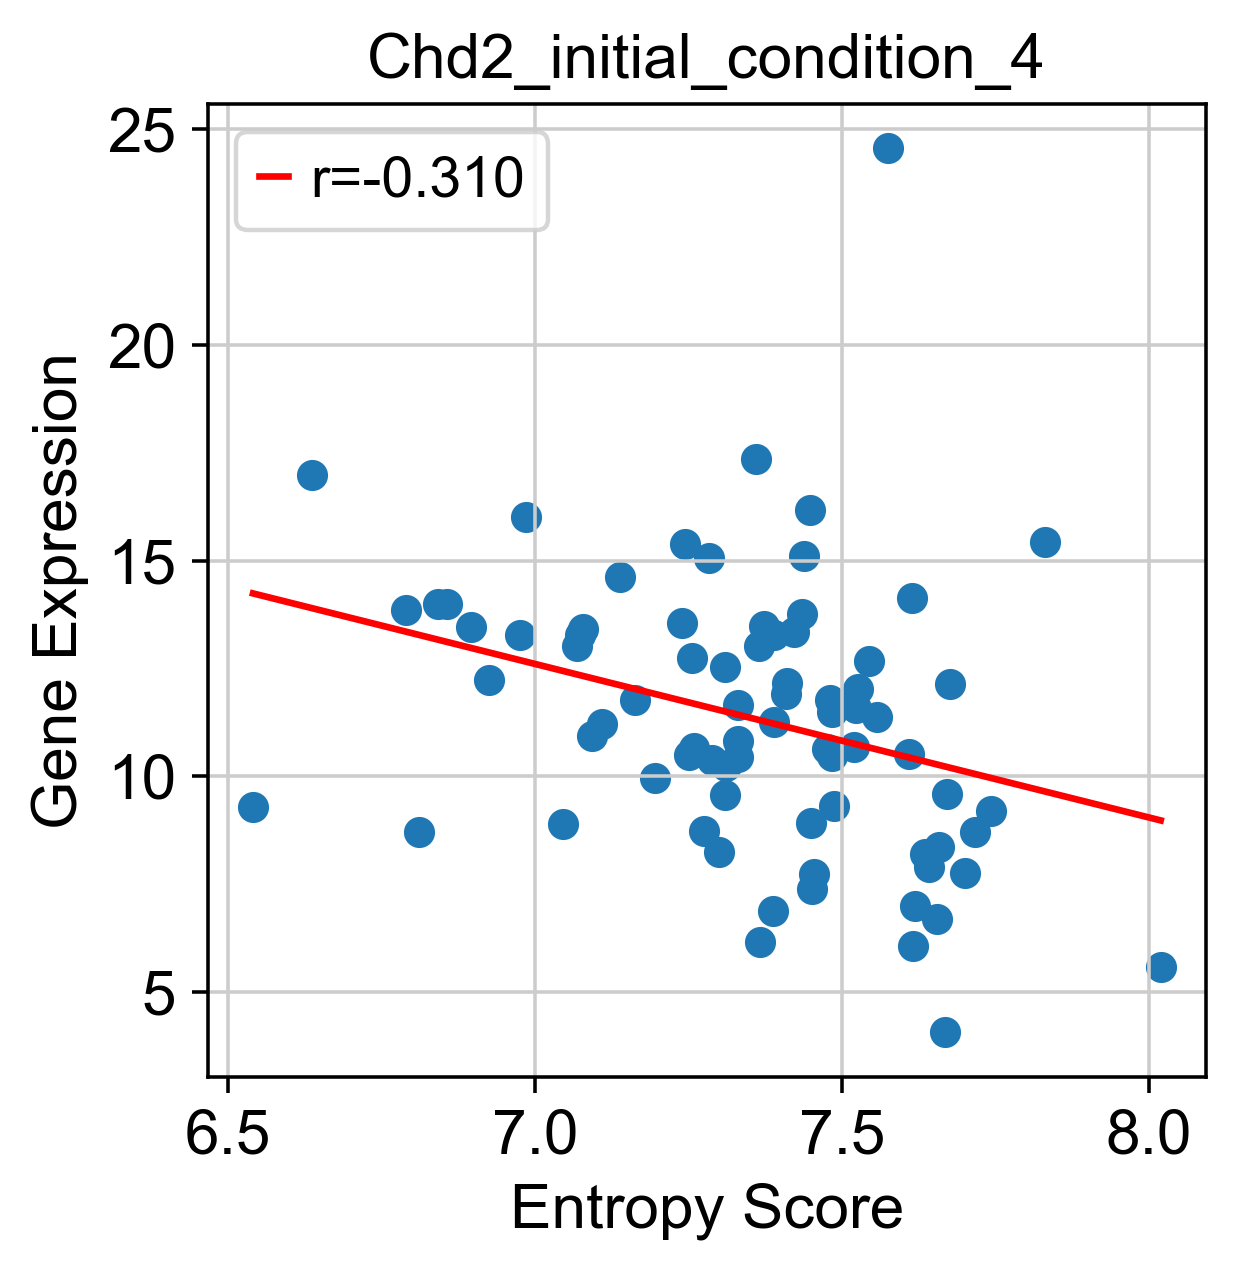

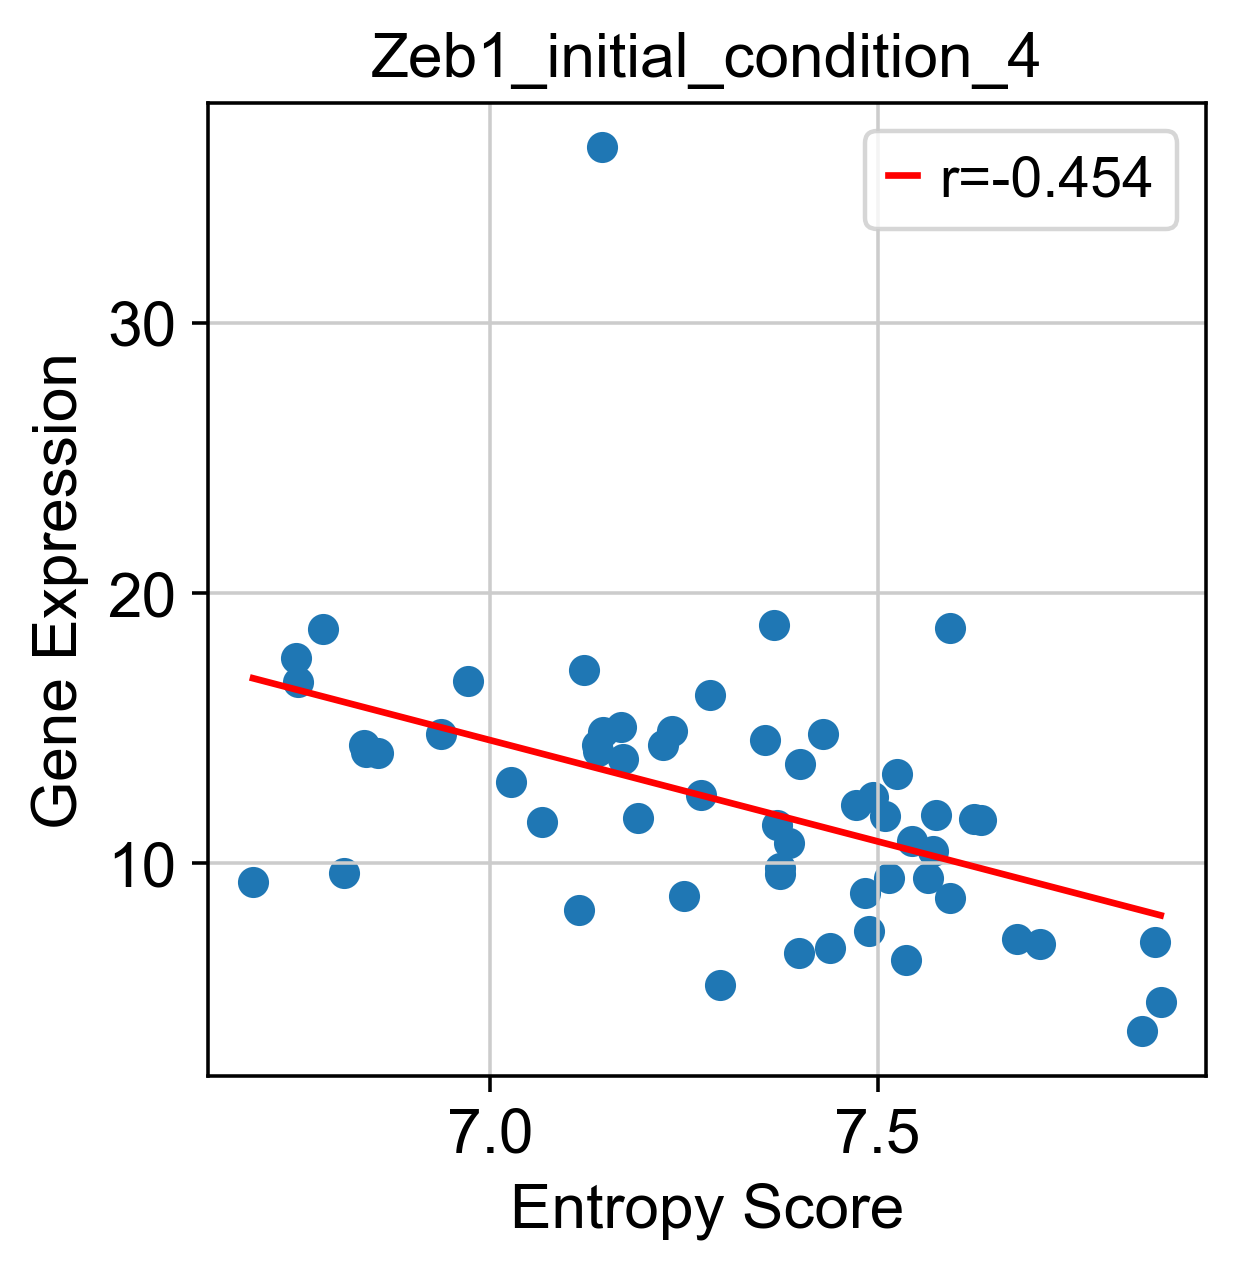

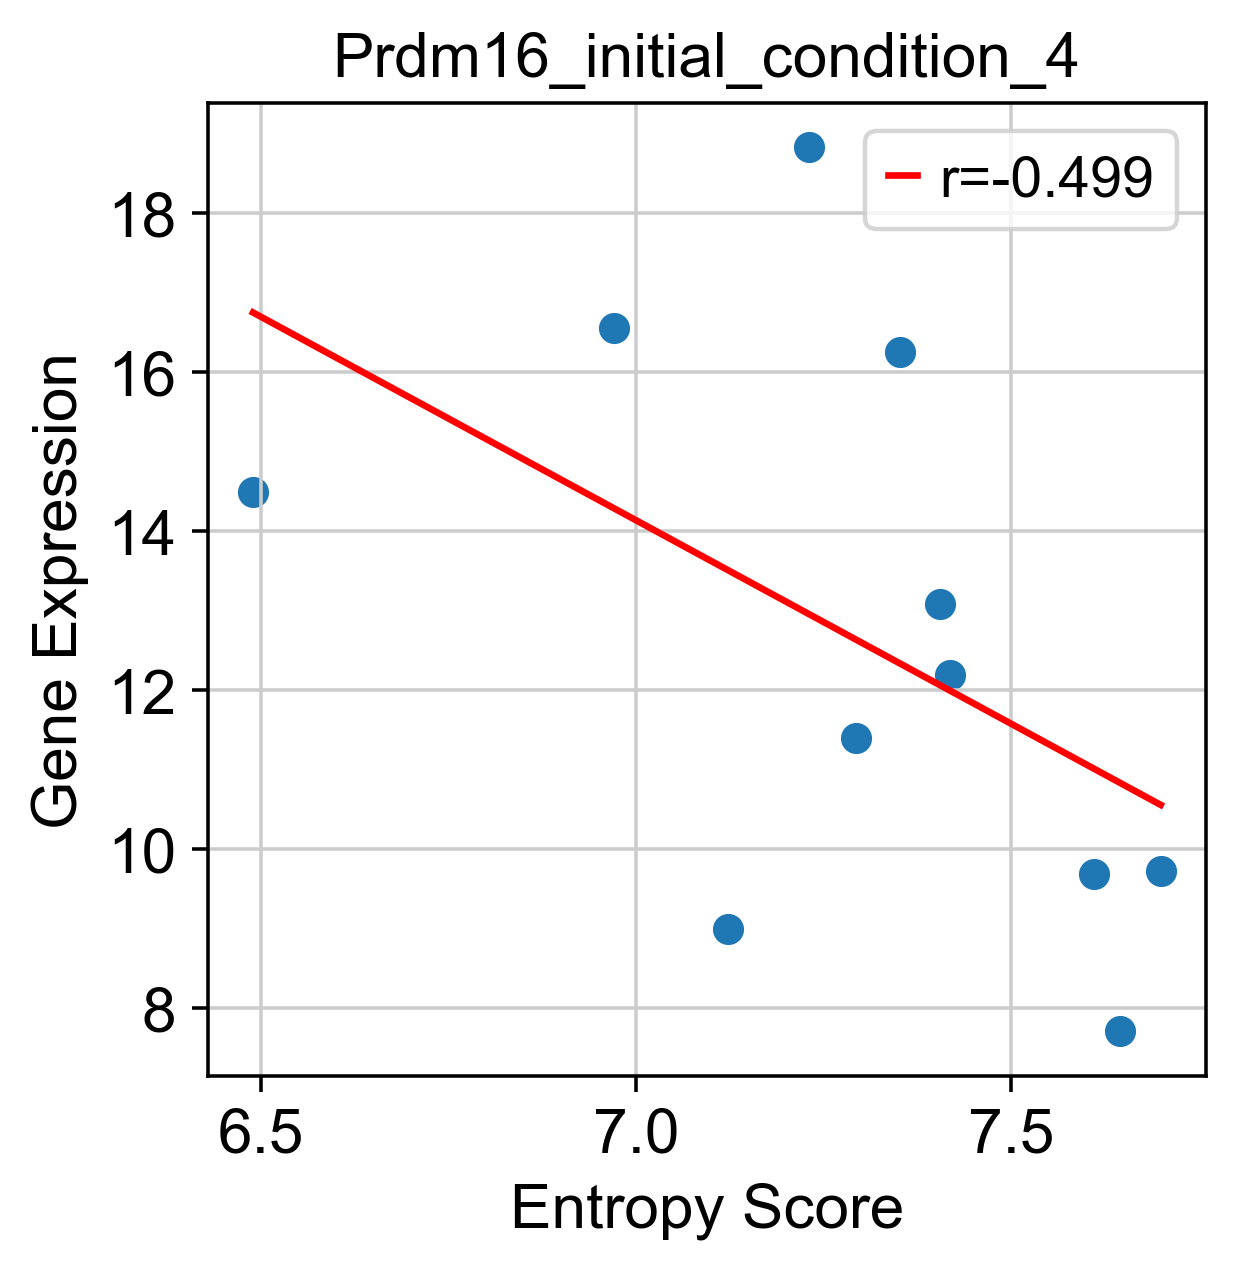

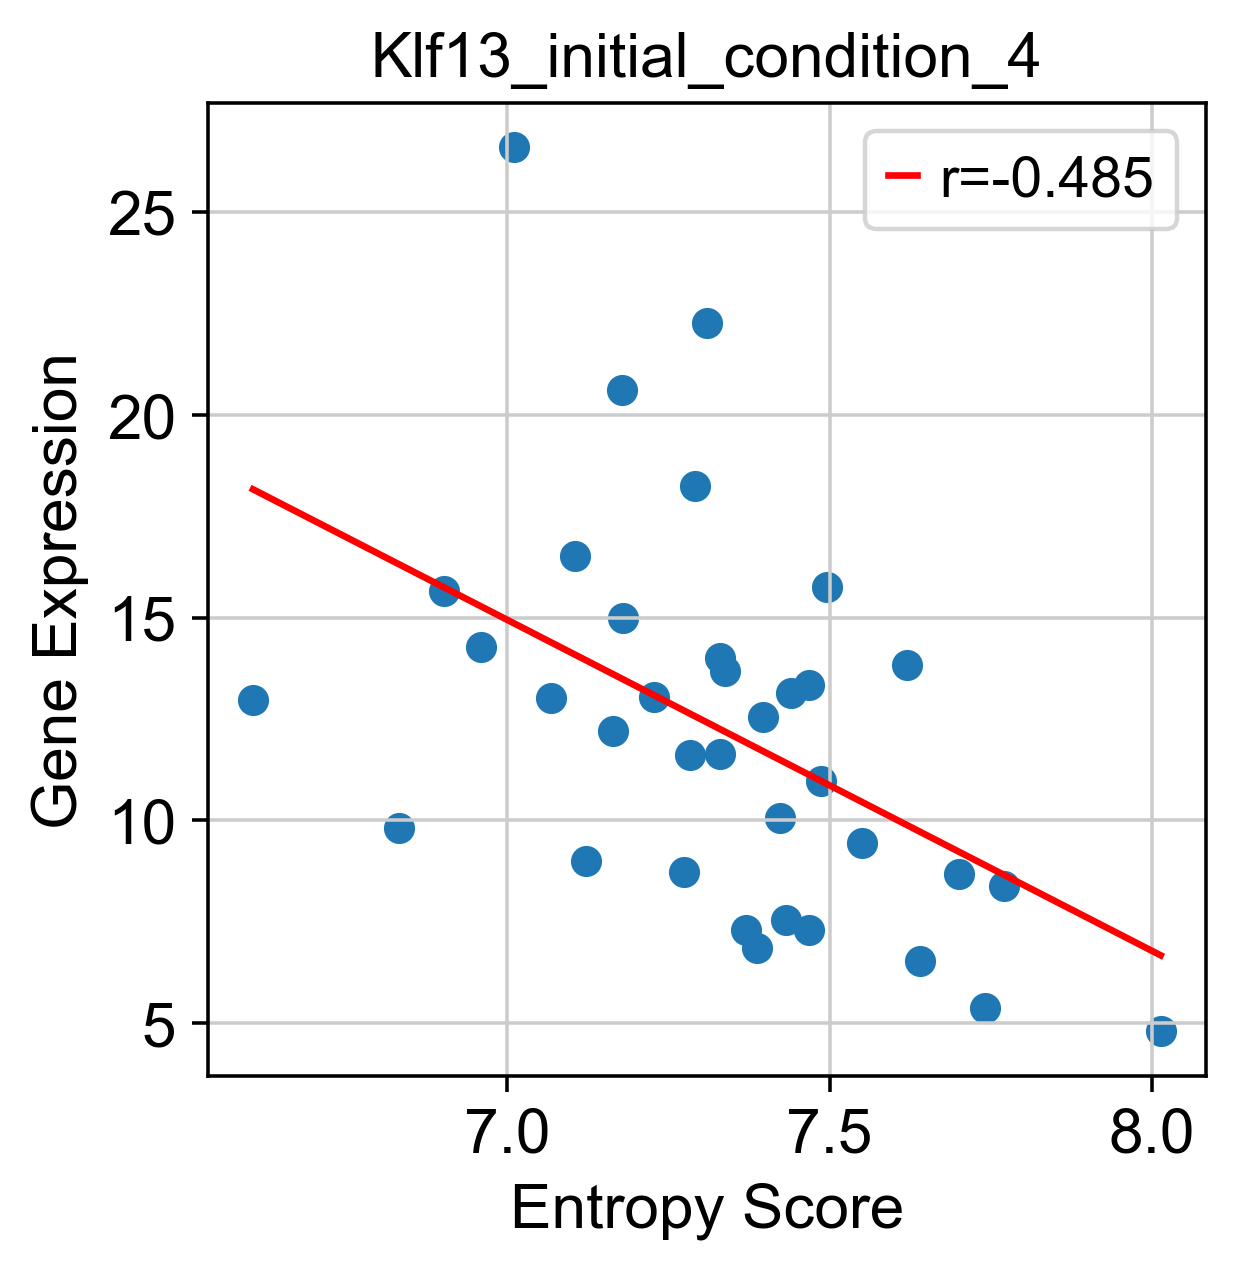

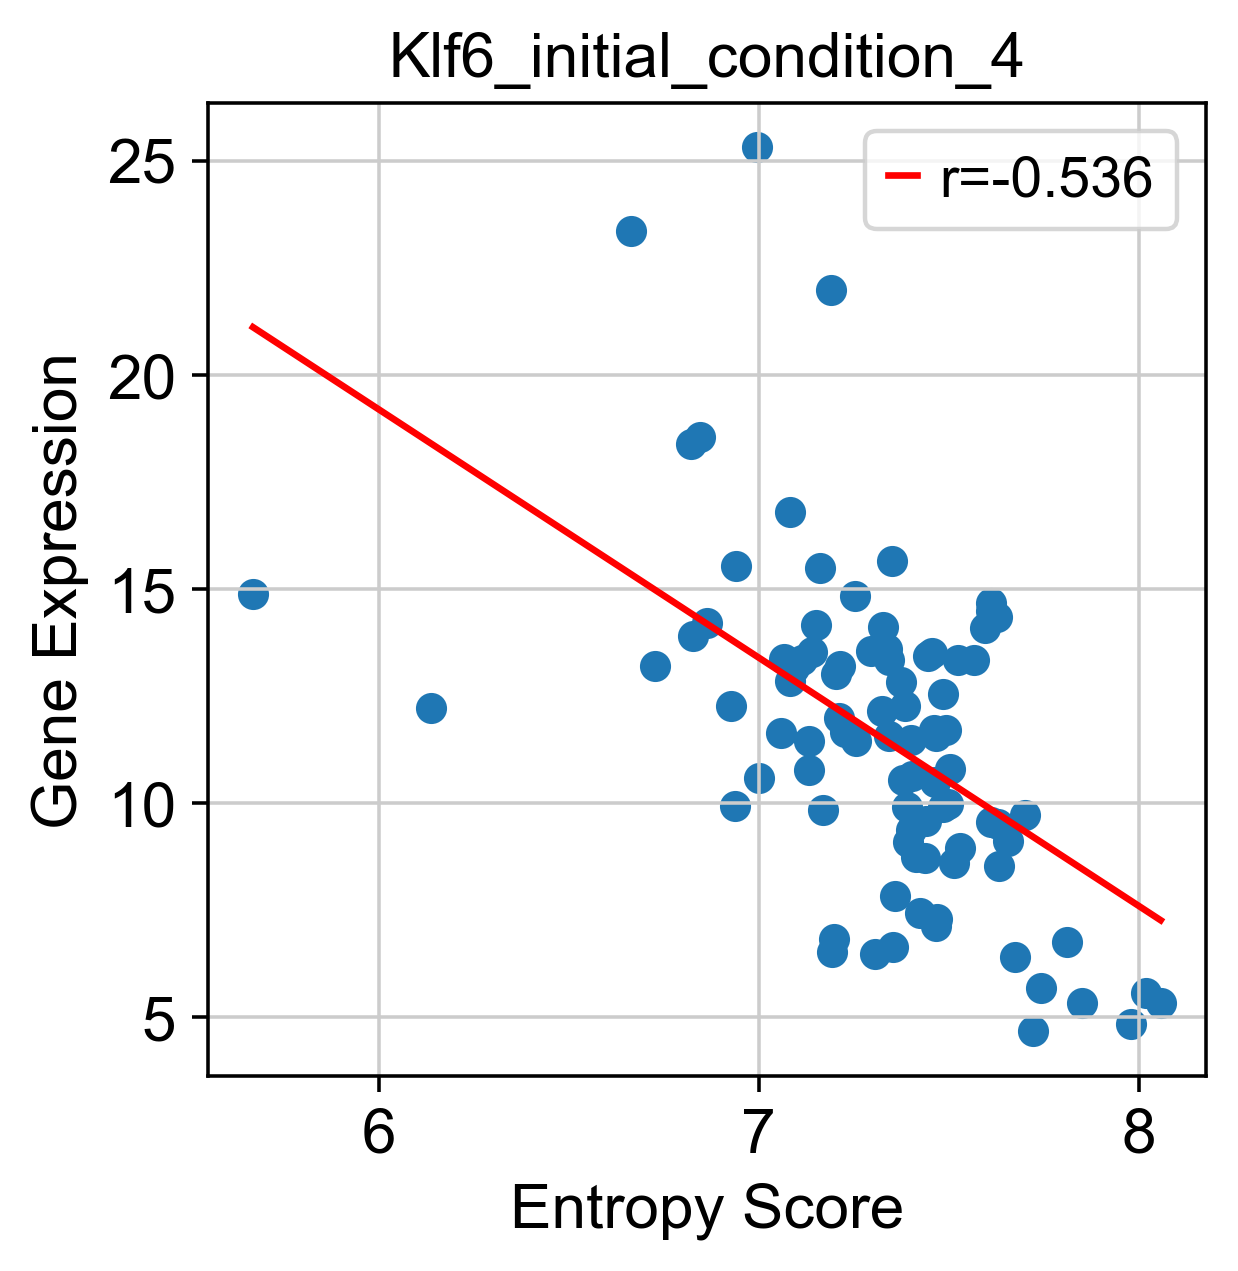

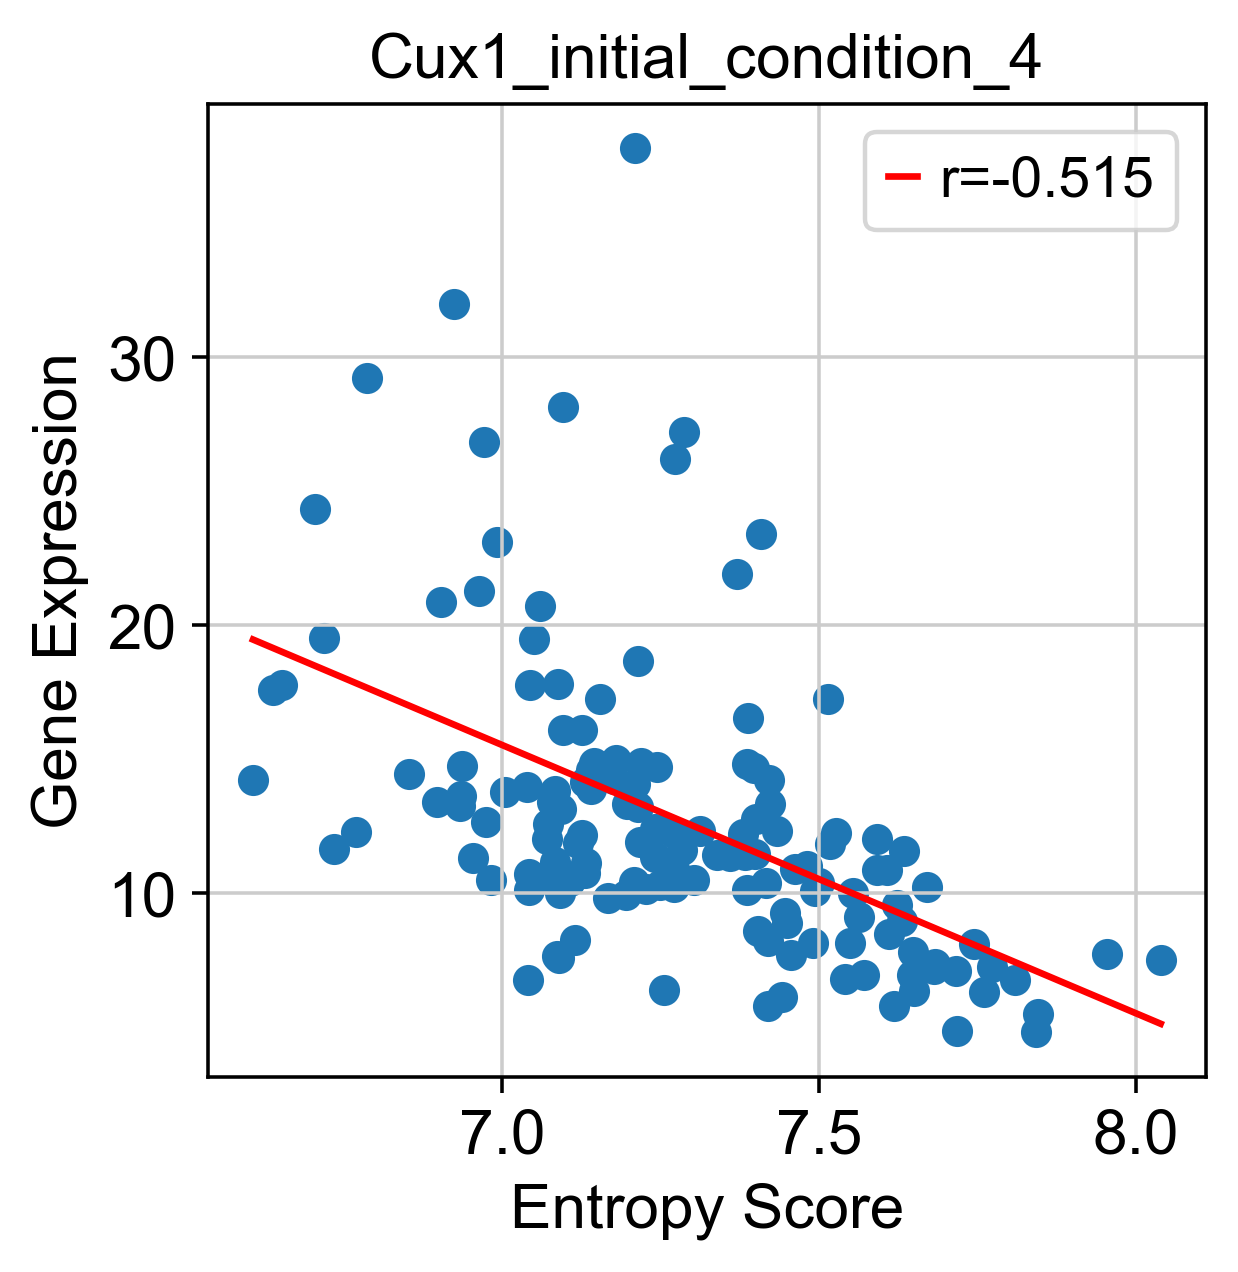

In [40]:
label = ['0', '4']
corr_dict = {}
for rowindex in range(len(tf_ip_df.index)):
    mysorted = tf_ip_df.iloc[rowindex,:].sort_values()

        
    for val in mysorted[0:6].index:
        if val not in adCM_proc.var.index:
            continue
        xval = queryEntropyScore
        yval = adCM_proc.X[:, adCM_proc.var.index == val]
        yval = np.array(yval).flatten()
        # remove 0 gene expression 
        xval = xval[yval > 0]
        yval = yval[yval > 0]
        plt.figure()
        plt.scatter(x=xval, y=yval)
        plt.title(f"{val}_initial_condition_{label[rowindex]}")
        plt.xlabel("Entropy Score")
        plt.ylabel("Gene Expression")
        slope, intercept, r, p, se = sp.stats.linregress(xval, yval)
        plt.plot(np.linspace(min(xval), max(xval), 400), 
                 np.linspace(min(xval), max(xval), 400) * slope + intercept, 
                 color='red', label=f"r={r:.3f}")
        plt.legend()
        plt.show()
        
    for tf in list(mysorted.index):
        if tf not in adCM_proc.var.index:
            continue
        xval = queryEntropyScore
        yval = adCM_proc.X[:, adCM_proc.var.index == val]
        yval = np.array(yval).flatten()  # remove 0 gene expression 
        xval = xval[yval > 0]
        yval = yval[yval > 0]
        slope, intercept, r, p, se = sp.stats.linregress(xval, yval)
        corr_dict[f"{tf}-{rowindex}"] = r
        
# as cells mature entropy score should decrease

In [41]:
np.array(list(corr_dict.values())) > 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,